# Sentiment Analysis of Amazon Reviews
# --- Hai Dang Vu (29348938) ---

## 1. Data Loading and Initial Exploration


In [23]:
# Import libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Load dataset
df = pd.read_csv("amazon_reviews.csv")

# Shape of the dataset
print(df.shape)

# Information about dataset
df.info()

# First 5 rows of dataset
df.head()

(17340, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sentiments             17340 non-null  object 
 1   cleaned_review         17337 non-null  object 
 2   cleaned_review_length  17340 non-null  int64  
 3   review_score           17340 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 542.0+ KB


,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


There are 3 missing values in `cleaned_review`

## 2. Data Cleaning

In [24]:
# Handle missing values
initial_count = len(df)
df = df.dropna(subset=["cleaned_review"])
print(f"Removed {initial_count - len(df)} rows with missing values")

# Remove duplicates
print('Initial duplicate count:', df.duplicated().sum())
df = df.drop_duplicates(subset=['cleaned_review', 'sentiments'])
print('Remaining duplicate count:', df.duplicated().sum())

Removed 3 rows with missing values
Initial duplicate count: 1347
Remaining duplicate count: 0


Removing 1350 rows of data (3 rows with missing value, 1347 rows duplicated) helps ensure quality but verify we're not losing important patterns

## 3. Exploratory Data Analysis (EDA)

### Sentiment distribution analysis

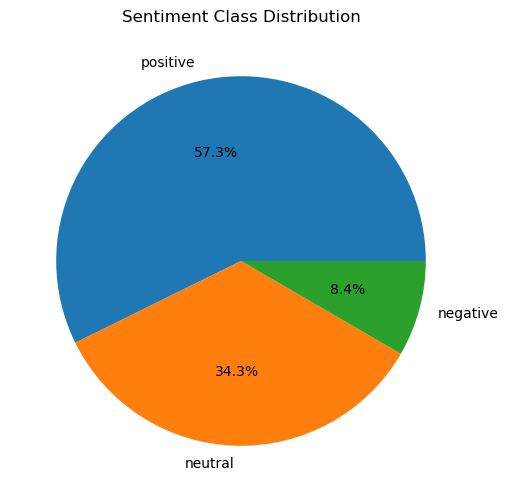

In [25]:
sentiment_dist = df['sentiments'].value_counts(normalize=True)
plt.figure(figsize=(8,6))
sentiment_dist.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Class Distribution')
plt.ylabel('')
plt.show()

Class imbalance evident with 58.8% positive reviews, meanwhile there is only 8.8% of negative ones which are relatively small compared to positive (58,8%) and neutral (36.3%).

As a result, we might consider apply SMOTE (synthetic Minority Over-sampling Technique) before training a model that can help it to learn classes equally to reduce overfitting risk.

### Review score distribution by sentiment


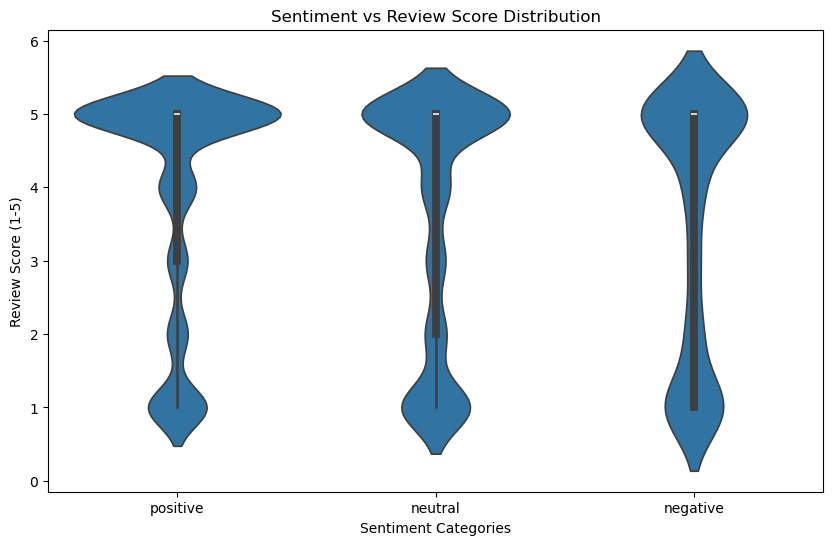

In [26]:
plt.figure(figsize=(10,6))
sns.violinplot(x=df["sentiments"], y=df["review_score"])
plt.title('Sentiment vs Review Score Distribution')
plt.xlabel('Sentiment Categories')
plt.ylabel('Review Score (1-5)')
plt.show()

From the plot above, we can see that:
* Higher scores (4-5) strongly correlate with positive sentiment
* Neutral reviews show wider score distribution

# 4. Text Analysis

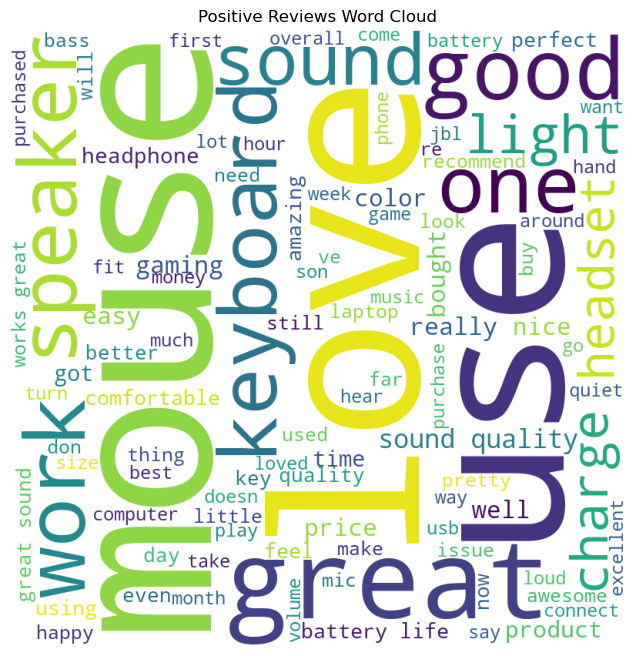

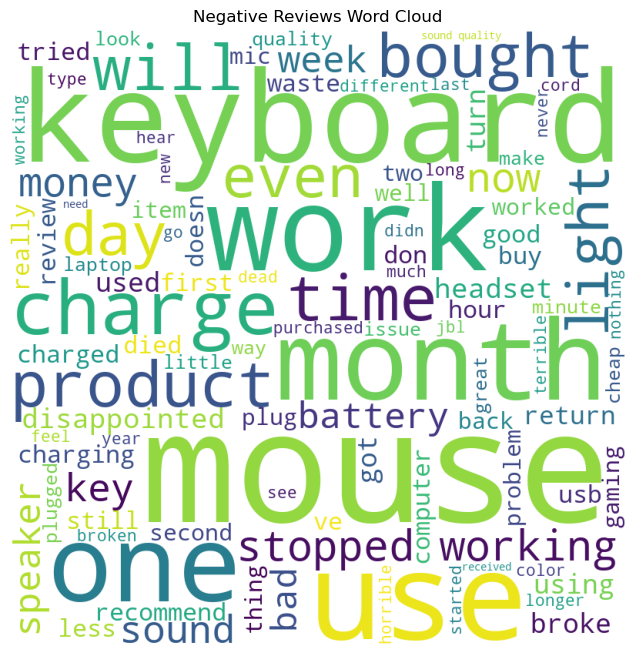

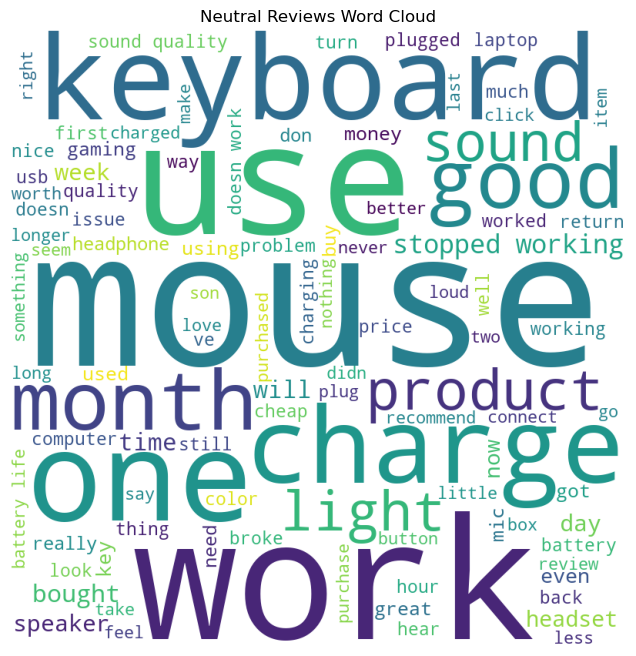

In [27]:
# Generate and display word cloud from text
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        stopwords=STOPWORDS,
        max_words=100,
    ).generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
# Positive reviews word cloud
positive_text = ' '.join(df[df['sentiments'] == 'positive']['cleaned_review'])
generate_wordcloud(positive_text, 'Positive Reviews Word Cloud')

# Negative reviews word cloud
negative_text = ' '.join(df[df['sentiments'] == 'negative']['cleaned_review'])
generate_wordcloud(negative_text, 'Negative Reviews Word Cloud')

# Neutral reviews word cloud
neutral_text = ' '.join(df[df['sentiments'] == 'neutral']['cleaned_review'])
generate_wordcloud(neutral_text, 'Neutral Reviews Word Cloud')

**Insights:**
* Positive reviews emphasize: "mouse", "love", "great"
* Negative reviews highlight: "mouse", "keyboard", "work", "month"
* Neutral reviews show mixed terminology

However, since we're considering individual word without the context so it's hard to tell if these words reflex the sentiment of the product reviews correctly or not. It's better to consider two words or three words together (eg: quite good, not bad, ...) that has more meaning.

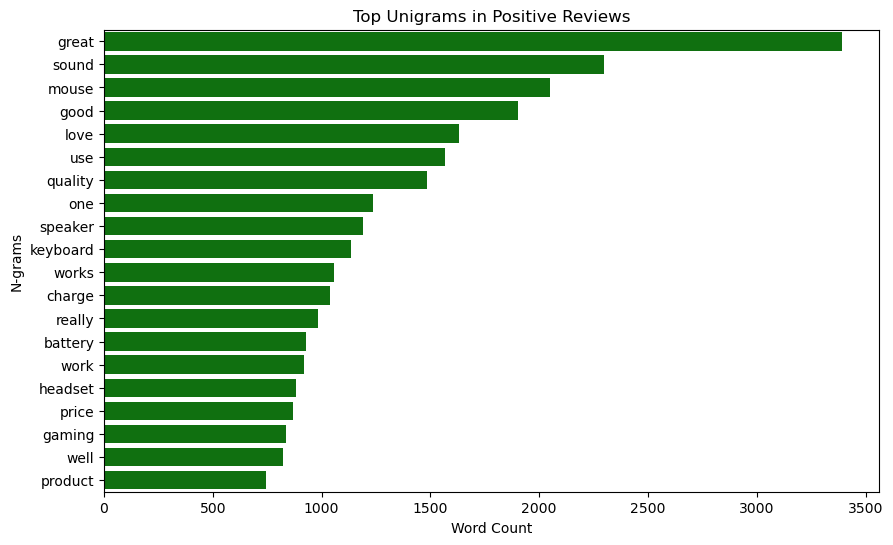

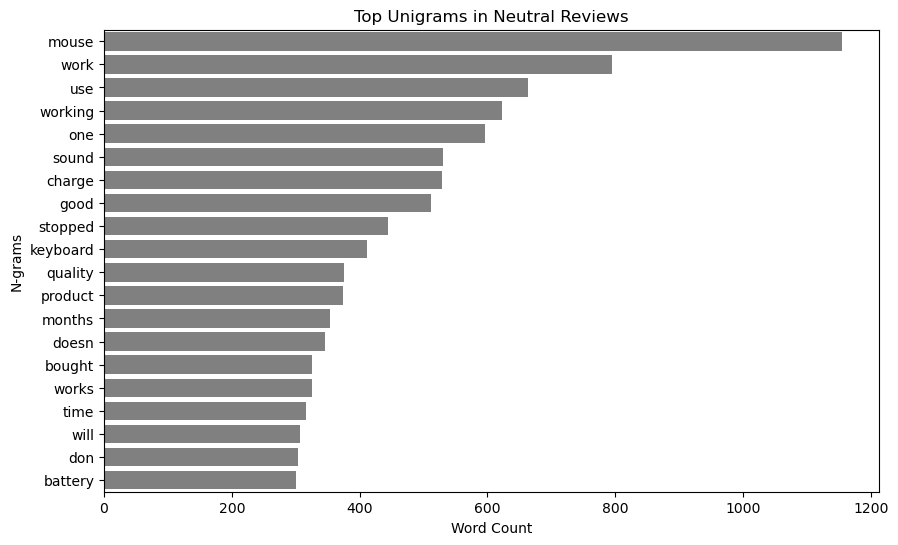

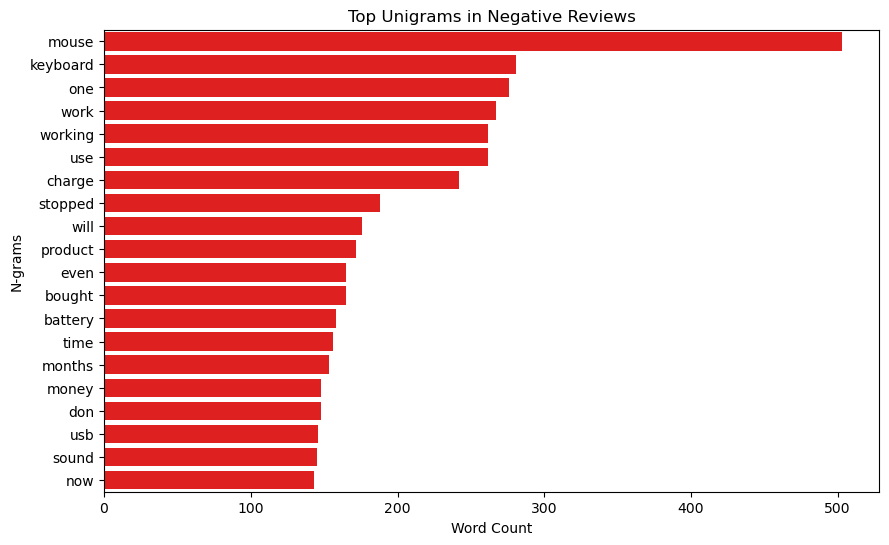

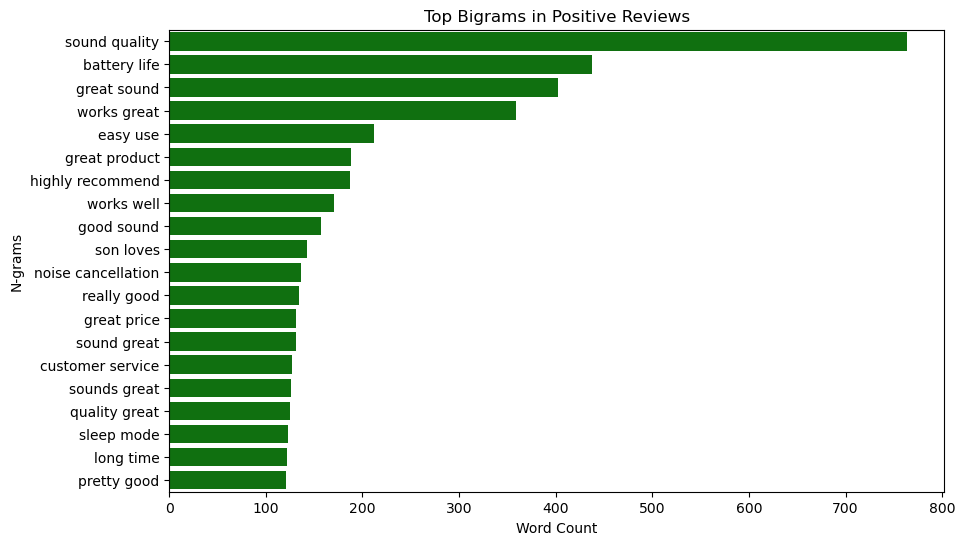

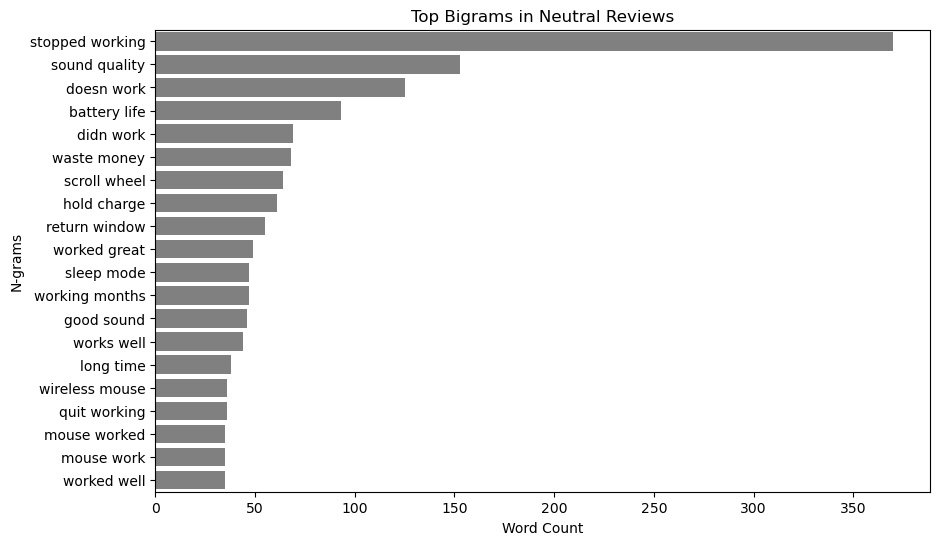

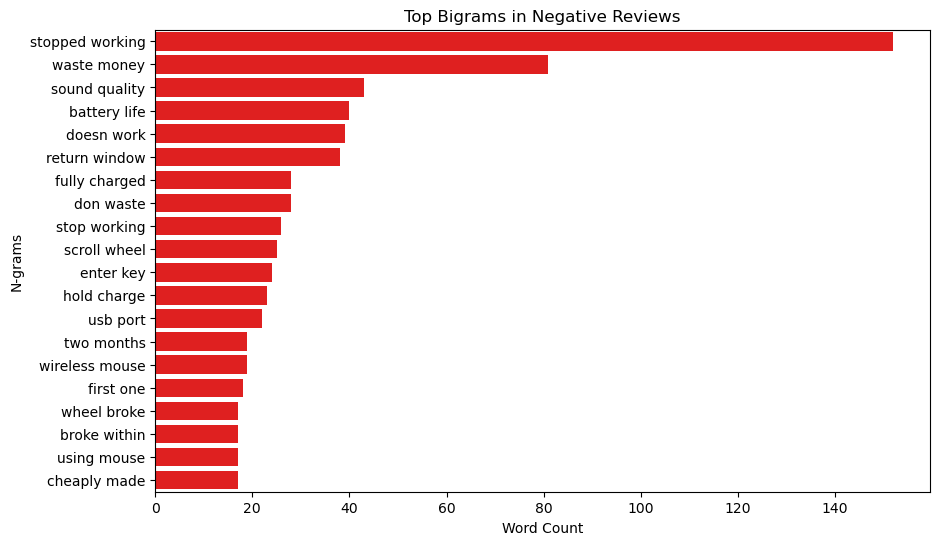

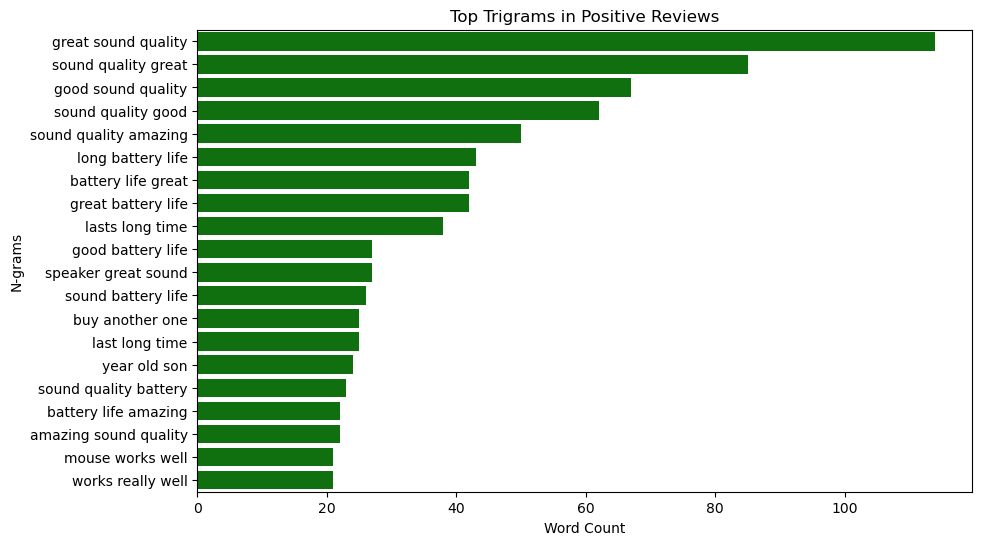

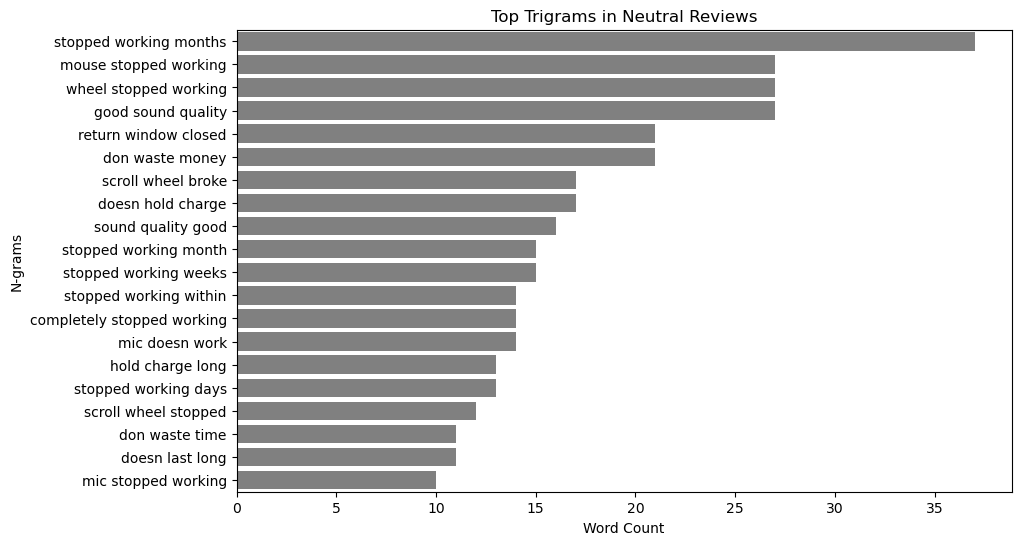

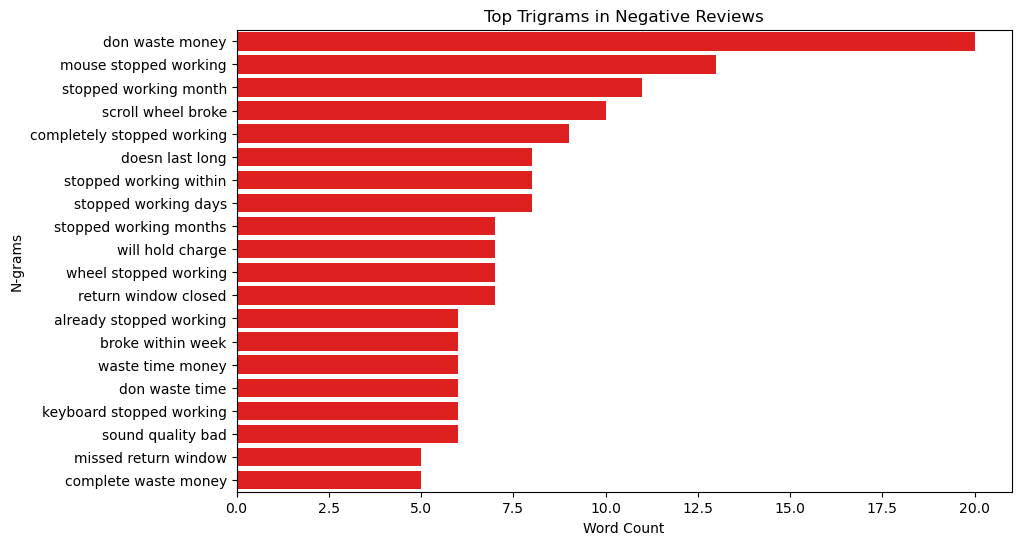

In [28]:
# code is taken from
# https://github.com/BenRoshan100/Sentiment-analysis-Amazon-reviews/blob/master/sentiment-analysis-amazon-reviews.ipynb
# and modified slightly by me

# Step 1: Filter the reviews by sentiment
review_pos = df[df["sentiments"].str.lower() == "positive"]
review_neu = df[df["sentiments"].str.lower() == "neutral"]
review_neg = df[df["sentiments"].str.lower() == "negative"]


# Step 2: Function to generate n-grams
def generate_ngrams(text, n_gram=1):
    tokens = [word for word in text.split() if word and word not in STOPWORDS]
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


# Step 3: Function to get top n-gram trace
def get_top_ngram_trace(reviews, n, head):
    freq_dict = defaultdict(int)
    for sent in reviews["cleaned_review"]:
        for ngram in generate_ngrams(sent, n_gram=n):
            freq_dict[ngram] += 1
    fd_sorted = pd.DataFrame(
        sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    )
    fd_sorted.columns = ["word", "wordcount"]
    return fd_sorted.head(head)


# Step 4: Plotting top n-grams for each sentiment
def plot_ngram_bars(data, title, color):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="wordcount", y="word", data=data, color=color)
    plt.title(title)
    plt.xlabel("Word Count")
    plt.ylabel("N-grams")
    plt.show()


# Step 5.1: Get top unigrams for each sentiment
top_pos_unigrams = get_top_ngram_trace(review_pos, n=1, head=20)
top_neu_unigrams = get_top_ngram_trace(review_neu, n=1, head=20)
top_neg_unigrams = get_top_ngram_trace(review_neg, n=1, head=20)

# Step 5.2: Get top bigrams for each sentiment
top_pos_bigrams = get_top_ngram_trace(review_pos, n=2, head=20)
top_neu_bigrams = get_top_ngram_trace(review_neu, n=2, head=20)
top_neg_bigrams = get_top_ngram_trace(review_neg, n=2, head=20)

# Step 5.3: Get top trigrams for each sentiment
top_pos_trigrams = get_top_ngram_trace(review_pos, n=3, head=20)
top_neu_trigrams = get_top_ngram_trace(review_neu, n=3, head=20)
top_neg_trigrams = get_top_ngram_trace(review_neg, n=3, head=20)

# Step 6: Plot each sentiment's n-grams
# 6.1: Unigrams
plot_ngram_bars(top_pos_unigrams, "Top Unigrams in Positive Reviews", "green")
plot_ngram_bars(top_neu_unigrams, "Top Unigrams in Neutral Reviews", "grey")
plot_ngram_bars(top_neg_unigrams, "Top Unigrams in Negative Reviews", "red")

# 6.2: Bigrams
plot_ngram_bars(top_pos_bigrams, "Top Bigrams in Positive Reviews", "green")
plot_ngram_bars(top_neu_bigrams, "Top Bigrams in Neutral Reviews", "grey")
plot_ngram_bars(top_neg_bigrams, "Top Bigrams in Negative Reviews", "red")

# 6.3: Trigrams
plot_ngram_bars(top_pos_trigrams, "Top Trigrams in Positive Reviews", "green")
plot_ngram_bars(top_neu_trigrams, "Top Trigrams in Neutral Reviews", "grey")
plot_ngram_bars(top_neg_trigrams, "Top Trigrams in Negative Reviews", "red")

As we can see:
* With unigram, most of top words (which appear the most in the reviews) such as mouse, working, etc can't reflex the sentiment in general.
* With Bigrams and Trigrams, it provides the context better that really help to identify sentiment better, so we can easily see some top word phases like don waste money (negative), mouse stopped working (negative), sounds quality (positive), work great (positive) exactly tell the sentiment of the reviews.

# **Solution 1:** Apply common Machine Leaning models

## 5. Preprocessing and Modelling

In [29]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    auc,
    ConfusionMatrixDisplay,
)

from sklearn.preprocessing import label_binarize

### Helper function to plot roc curve

In [30]:
def plot_roc_curve(y_test, y_score, class_names, title):
    # ROC plotting for multi-class
    # Binarize the test labels (for 3 classes)
    y_test_bin = label_binarize(y_test, classes=list(range(len(class_names))))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(
            fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})"
        )
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
        linestyle="--",
    )
    plt.plot([0, 1], [0, 1], "k:", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

### Helper function to evaluate a model

In [31]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=None):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions on the training set
    y_pred_train = model.predict(X_train)
    y_pred_prob_train = model.predict_proba(X_train)  # returns a list of 3 arrays
    # Make predictions on the test set
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test)  # returns a list of 3 arrays

    # Calculate metrics for training set
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(
        y_train, y_pred_train, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    train_recall = recall_score(
        y_train, y_pred_train, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    train_f1 = f1_score(
        y_train, y_pred_train, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    train_roc_auc = roc_auc_score(y_train, y_pred_prob_train, multi_class="ovr")

    # Calculate metrics for test set
    test_accuracy = accuracy_score(
        y_test, y_pred_test
    )  # Use 'weighted' to account for class imbalance
    test_precision = precision_score(
        y_test, y_pred_test, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    test_recall = recall_score(
        y_test, y_pred_test, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    test_f1 = f1_score(
        y_test, y_pred_test, average="weighted"
    )  # Use 'weighted' to account for class imbalance
    test_roc_auc = roc_auc_score(y_test, y_pred_prob_test, multi_class="ovr")

    # Print the ROC AUC scores
    print(f"Train ROC AUC: {train_roc_auc:.4f}")
    print(f"Test ROC AUC: {test_roc_auc :.4f}")

    # Print the classification report for training set
    print("Classification report on train set:")
    print(classification_report(y_train, y_pred_train))
    # Plot ROC curve for training set
    plot_roc_curve(
        y_train,
        y_pred_prob_train,
        class_names,
        title="ROC Curve (One-vs-Rest) - Train Set",
    )

    # Plot confusion matrix for training set
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
        model, X_train, y_train, cmap="Blues", display_labels=class_names
    )
    plt.title("Confusion Matrix - Train Set")
    plt.show()

    # Print the classification report for test set
    print("Classification report on test set:")
    print(classification_report(y_test, y_pred_test))
    # Plot ROC curve for test set
    plot_roc_curve(
        y_test,
        y_pred_prob_test,
        class_names,
        title="ROC Curve (One-vs-Rest) - Test Set",
    )
    # Plot confusion matrix for test set
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, cmap="Blues", display_labels=class_names
    )
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    return [
        train_accuracy,
        train_precision,
        train_recall,
        train_f1,
        train_roc_auc,
        test_accuracy,
        test_precision,
        test_recall,
        test_f1,
        test_roc_auc,
    ]

In [32]:
# Create a score dataframe to store the metrics of different models for easy comparison
score = pd.DataFrame(
    index=[
        "Train Accuracy",
        "Train Precision",
        "Train Recall",
        "Train F1",
        "Train ROC AUC",
        "Test Accuracy",
        "Test Precision",
        "Test Recall",
        "Test F1",
        "Test ROC AUC",
    ]
)

In [33]:
from scipy.stats import loguniform

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Download required NLTK resources
nltk.download("punkt")

# Prepare features and target
X = df["cleaned_review"]
y = df["sentiments"]

# Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Stratified split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


stemmer = PorterStemmer()


def stem_tokenizer(text):
    try:
        tokens = word_tokenize(text)
        return [stemmer.stem(token) for token in tokens]
    except:
        return []  # Return empty list for problematic texts

[nltk_data] Downloading package punkt to C:\Users\tamqu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Starting randomized grid search...
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Best model evaluation:
Train ROC AUC: 0.9677
Test ROC AUC: 0.9223
Classification report on train set:
              precision    recall  f1-score   support

           0       0.61      0.90      0.73       884
           1       0.84      0.82      0.83      3623
           2       0.95      0.90      0.92      6047

    accuracy                           0.87     10554
   macro avg       0.80      0.87      0.83     10554
weighted avg       0.89      0.87      0.88     10554



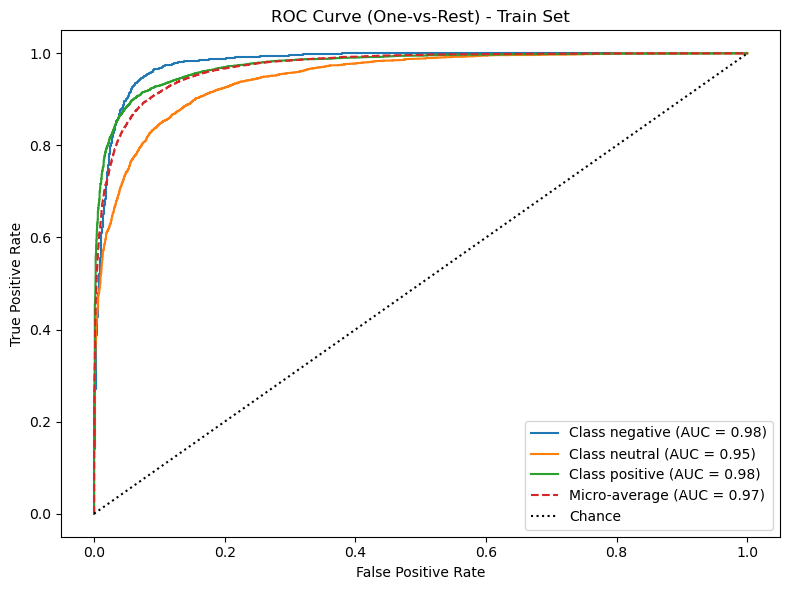

<Figure size 800x600 with 0 Axes>

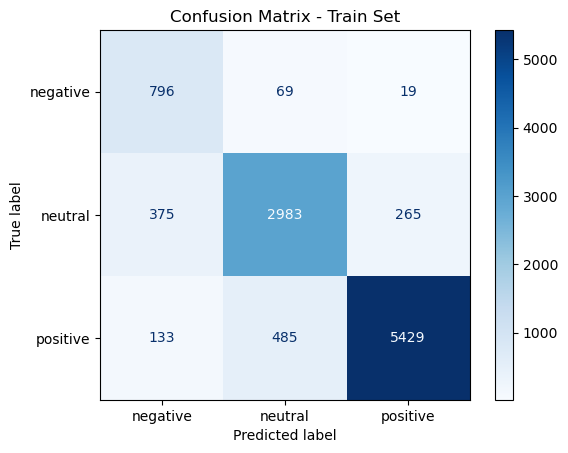

Classification report on test set:
              precision    recall  f1-score   support

           0       0.43      0.72      0.54       221
           1       0.75      0.70      0.73       906
           2       0.91      0.86      0.89      1512

    accuracy                           0.80      2639
   macro avg       0.70      0.76      0.72      2639
weighted avg       0.82      0.80      0.80      2639



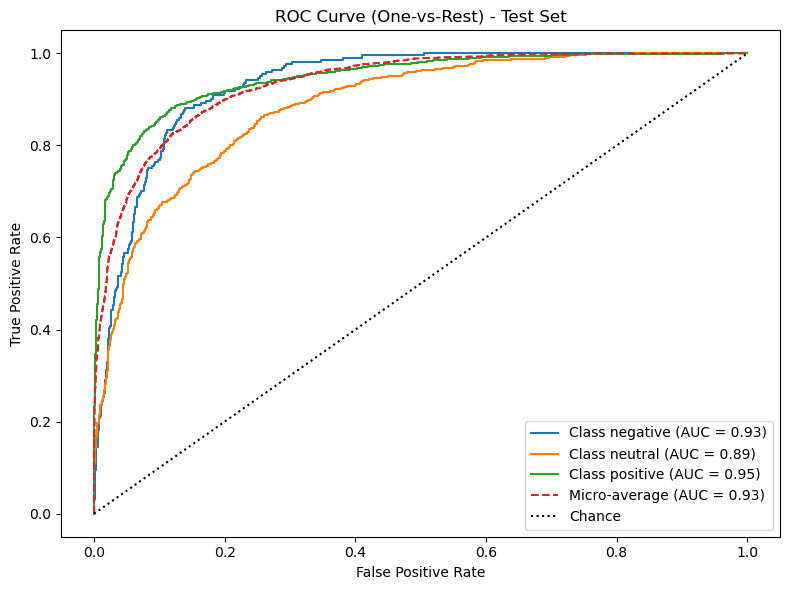

<Figure size 800x600 with 0 Axes>

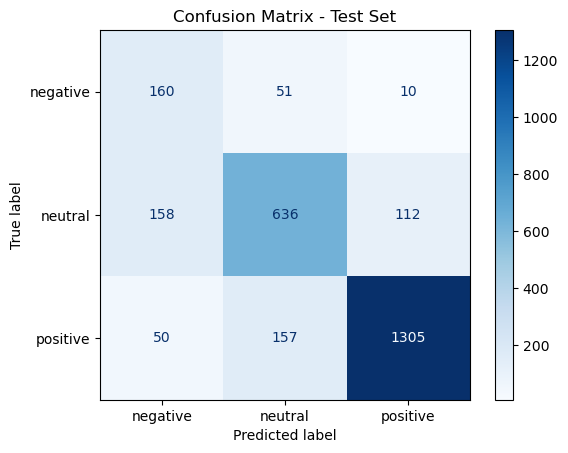

In [ ]:
# Create pipeline with SMOTE
pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer, # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        ("smote", SMOTE(random_state=42)), # Handle class imbalance
        (
            "classifier",
            LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
        ),
    ]
)

# Define parameter grid for random search
param_dist = {
    "tfidf__max_features": [1000, 5000, 10000, None], # Number of features
    "tfidf__ngram_range": [(1, 1), (1, 2)], # Unigrams and bigrams
    "smote__k_neighbors": [3, 5, 7], # Number of nearest neighbors
    "classifier__C": loguniform(1e-3, 100),  # Log-uniform distribution for C
    "classifier__solver": ["lbfgs", "liblinear", "sag"], # Different solvers
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter combinations to try
    scoring="accuracy", # Optimize for accuracy
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1,
)

# Perform random search on training data
print("Starting randomized grid search...")
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate the best model
print("\nBest model evaluation:")
score['Logistic Regression'] = evaluate_model(best_model, X_train, y_train, X_test, y_test, le.classes_)

Starting randomized grid search...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best model evaluation:
Train ROC AUC: 0.9778
Test ROC AUC: 0.8601
Classification report on train set:
              precision    recall  f1-score   support

           0       0.99      0.78      0.88       884
           1       0.84      0.93      0.89      3623
           2       0.96      0.92      0.94      6047

    accuracy                           0.91     10554
   macro avg       0.93      0.88      0.90     10554
weighted avg       0.92      0.91      0.92     10554



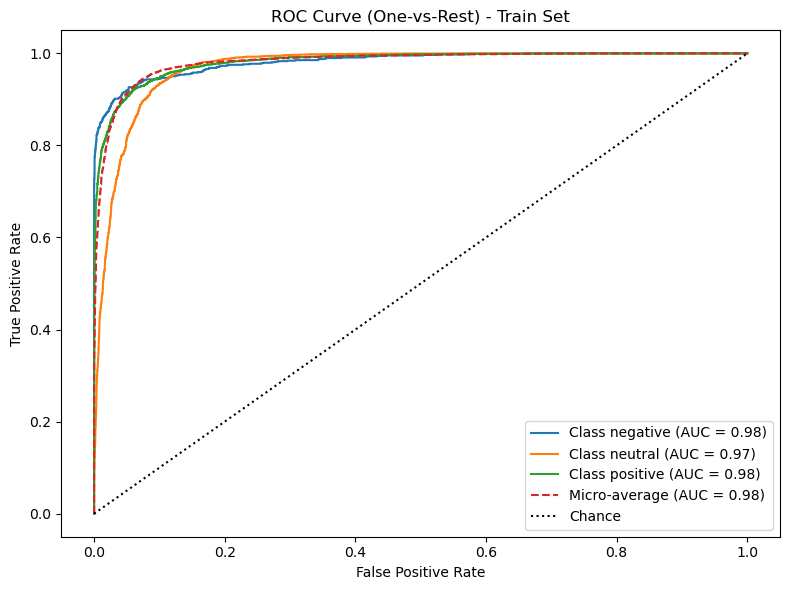

<Figure size 800x600 with 0 Axes>

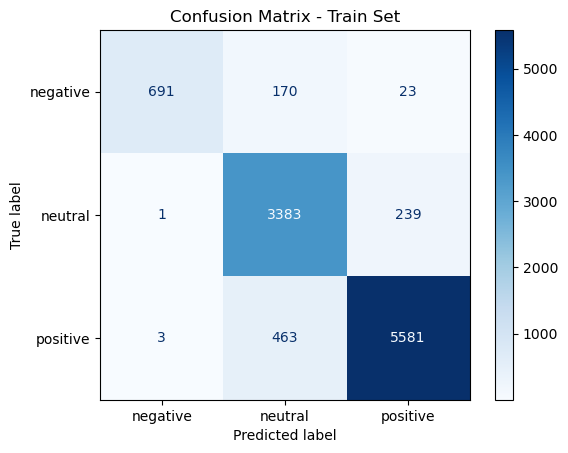

Classification report on test set:
              precision    recall  f1-score   support

           0       0.34      0.37      0.36       221
           1       0.69      0.70      0.69       906
           2       0.84      0.83      0.83      1512

    accuracy                           0.74      2639
   macro avg       0.62      0.63      0.63      2639
weighted avg       0.75      0.74      0.75      2639



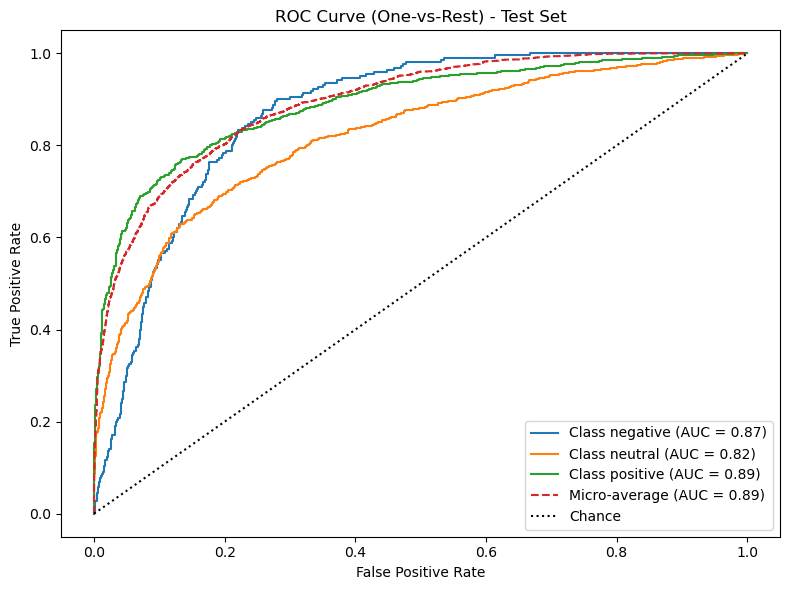

<Figure size 800x600 with 0 Axes>

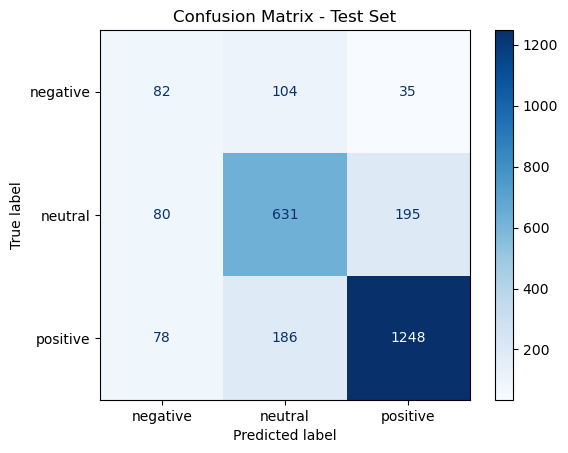

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create pipeline with SMOTE
pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer,  # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        ("smote", SMOTE(random_state=42)),  # Handle class imbalance
        (
            (
                "classifier",
                RandomForestClassifier(class_weight="balanced", random_state=42),
            )
        ),
    ]
)

# Define parameter grid for random search
param_dist = {
    "tfidf__max_features": [5000, 10000],
    "tfidf__ngram_range": [(1, 1)],
    "smote__k_neighbors": [3, 5],
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter combinations to try
    scoring="accuracy",  # Optimize for accuracy
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1,
)

# Perform random search on training data
print("Starting randomized grid search...")
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate the best model
print("\nBest model evaluation:")
score["Random Forest"] = evaluate_model(
    best_model, X_train, y_train, X_test, y_test, le.classes_
)

In [39]:
score

,Logistic Regression,Random Forest
Train Accuracy,0.872465,0.914819
Train Precision,0.885119,0.919719
Train Recall,0.872465,0.914819
Train F1,0.875992,0.915238
Train ROC AUC,0.967737,0.977843
Test Accuracy,0.796135,0.743085
Test Precision,0.819076,0.747609
Test Recall,0.796135,0.743085
Test F1,0.803843,0.745218
Test ROC AUC,0.922255,0.860097


# **Solution 2:** Apply Deep Learning

### Use Multiple Layer Peceptron

Starting randomized grid search...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best model evaluation:
Train ROC AUC: 0.9723
Test ROC AUC: 0.9312
Classification report on train set:
              precision    recall  f1-score   support

           0       0.68      0.90      0.78       884
           1       0.86      0.82      0.84      3623
           2       0.94      0.92      0.93      6047

    accuracy                           0.89     10554
   macro avg       0.83      0.88      0.85     10554
weighted avg       0.89      0.89      0.89     10554



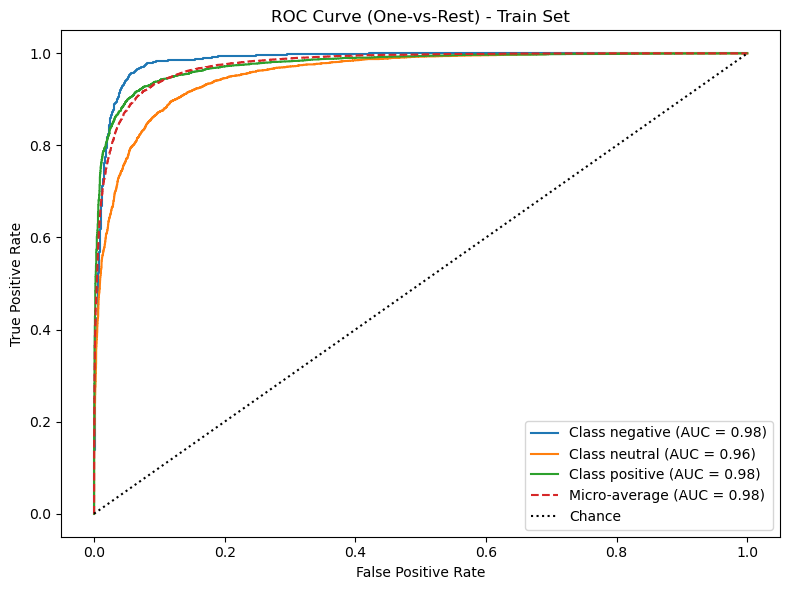

<Figure size 800x600 with 0 Axes>

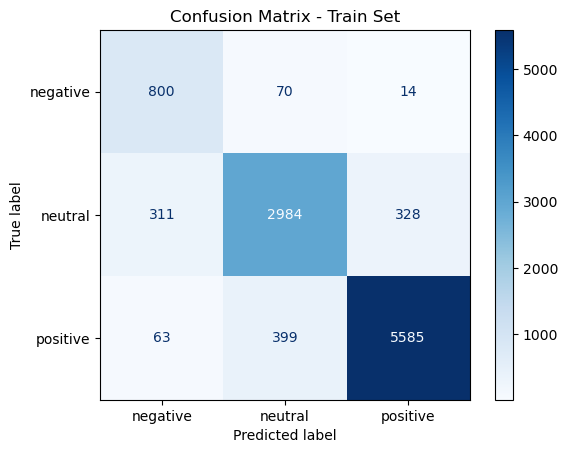

Classification report on test set:
              precision    recall  f1-score   support

           0       0.49      0.72      0.58       221
           1       0.77      0.72      0.74       906
           2       0.91      0.88      0.90      1512

    accuracy                           0.81      2639
   macro avg       0.72      0.77      0.74      2639
weighted avg       0.82      0.81      0.82      2639



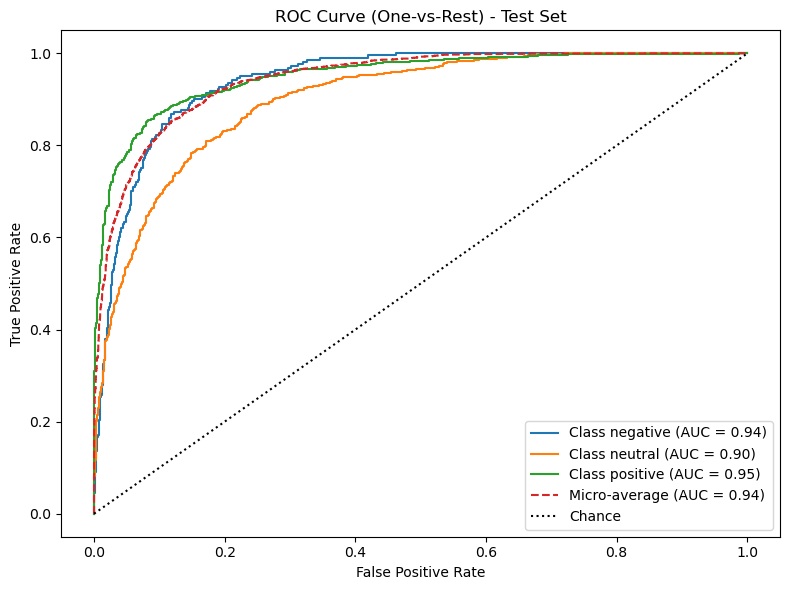

<Figure size 800x600 with 0 Axes>

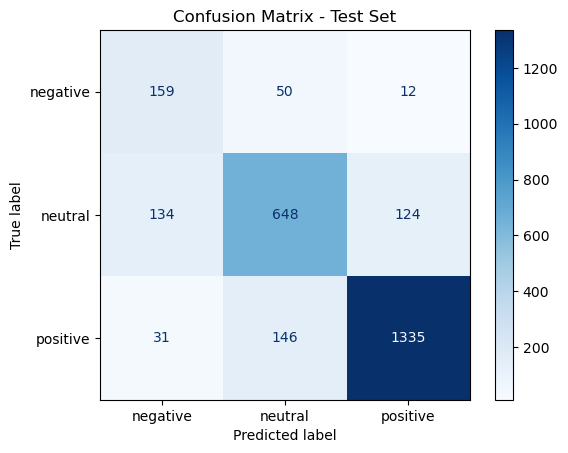

In [41]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     ConfusionMatrixDisplay,
# )
# import seaborn as sns
# import matplotlib.pyplot as plt

pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer, # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        ("smote", SMOTE(random_state=42)), # Handle class imbalance
        (
            "classifier",
            MLPClassifier(max_iter=300, random_state=42, early_stopping=True),
        ),
    ]
)

# Define parameter grid for random search
param_dist = {
    "tfidf__max_features": [1000, 5000, 10000, None], # Number of features
    "tfidf__ngram_range": [(1, 1), (1, 2)], # Unigrams and bigrams
    "smote__k_neighbors": [3, 5, 7], # Number of nearest neighbors
    "classifier__hidden_layer_sizes": [(128,), (128, 64)],
    "classifier__activation": ["relu", "tanh"],
    "classifier__solver": ["adam", "sgd"],
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter combinations to try
    scoring="accuracy", # Optimize for accuracy
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1,
)

# Perform random search on training data
print("Starting randomized grid search...")
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate the best model
print("\nBest model evaluation:")
score['MLP'] = evaluate_model(best_model, X_train, y_train, X_test, y_test, le.classes_)

# Create pipeline to extract and build model
# pipeline = Pipeline(
#     [
#         ("vect", CountVectorizer()),
#         ("tfidf", TfidfTransformer()),
#         ("clf", MLPClassifier(max_iter=300, random_state=42, early_stopping=True)),
#     ]
# )

# Possible hyper-paramenters
# param_grid = {
#     "clf__hidden_layer_sizes": [(64,), (128,), (128, 64)],
#     "clf__activation": ["relu", "tanh"],
#     "clf__solver": ["adam", "sgd"],
# }

# # Run grid search using list of possible hyper-paramenters using cross-validation technique to get the best model
# grid = GridSearchCV(
#     pipeline, param_grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=2
# )
# grid.fit(train_val_df["cleaned_review"], train_val_df["label_encoded"])

# print("Best Params:", grid.best_params_)
# print("Best CV Score:", grid.best_score_)

# # Use the best estimator (model) to make prediction on test set
# best_model = grid.best_estimator_
# test_preds = best_model.predict(test_df["cleaned_review"])

# # Evaluate the model
# evaluate_model(
#     best_model,
#     train_val_df["cleaned_review"],
#     train_val_df["label_encoded"],
#     test_df["cleaned_review"],
#     test_df["label_encoded"],
#     label_encoder.classes_,
# )


In [42]:
score

,Logistic Regression,Random Forest,MLP
Train Accuracy,0.872465,0.914819,0.887720
Train Precision,0.885119,0.919719,0.893630
Train Recall,0.872465,0.914819,0.887720
Train F1,0.875992,0.915238,0.889135
Train ROC AUC,0.967737,0.977843,0.972269
Test Accuracy,0.796135,0.743085,0.811671
Test Precision,0.819076,0.747609,0.824655
Test Recall,0.796135,0.743085,0.811671
Test F1,0.803843,0.745218,0.815937
Test ROC AUC,0.922255,0.860097,0.931173


# Way 2: Use Naive Bayes

Starting randomized grid search...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best model evaluation:
Train ROC AUC: 0.9339
Test ROC AUC: 0.8544
Classification report on train set:
              precision    recall  f1-score   support

           0       0.42      0.93      0.58       884
           1       0.80      0.55      0.65      3623
           2       0.87      0.87      0.87      6047

    accuracy                           0.77     10554
   macro avg       0.70      0.79      0.70     10554
weighted avg       0.81      0.77      0.77     10554



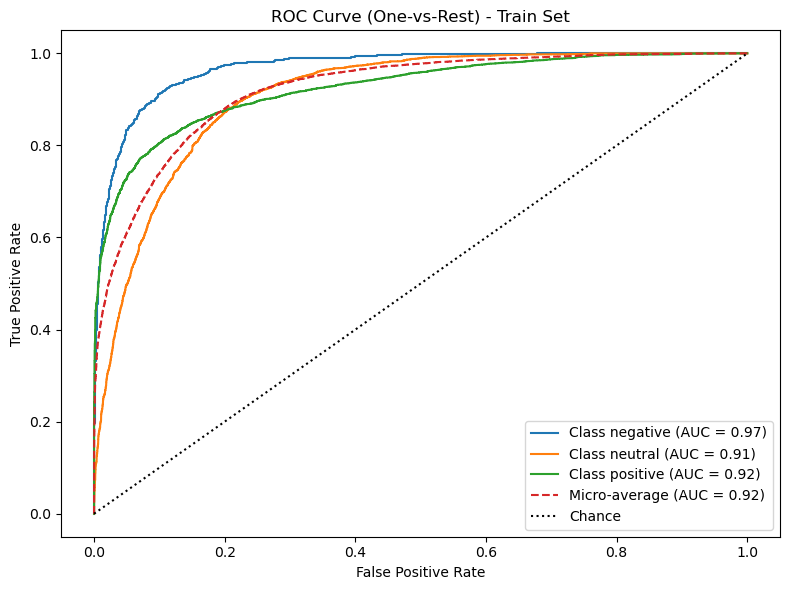

<Figure size 800x600 with 0 Axes>

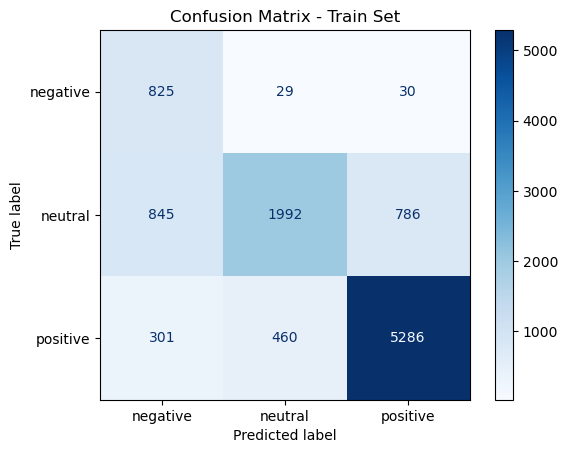

Classification report on test set:
              precision    recall  f1-score   support

           0       0.29      0.76      0.42       221
           1       0.62      0.34      0.44       906
           2       0.81      0.84      0.83      1512

    accuracy                           0.66      2639
   macro avg       0.57      0.65      0.56      2639
weighted avg       0.70      0.66      0.66      2639



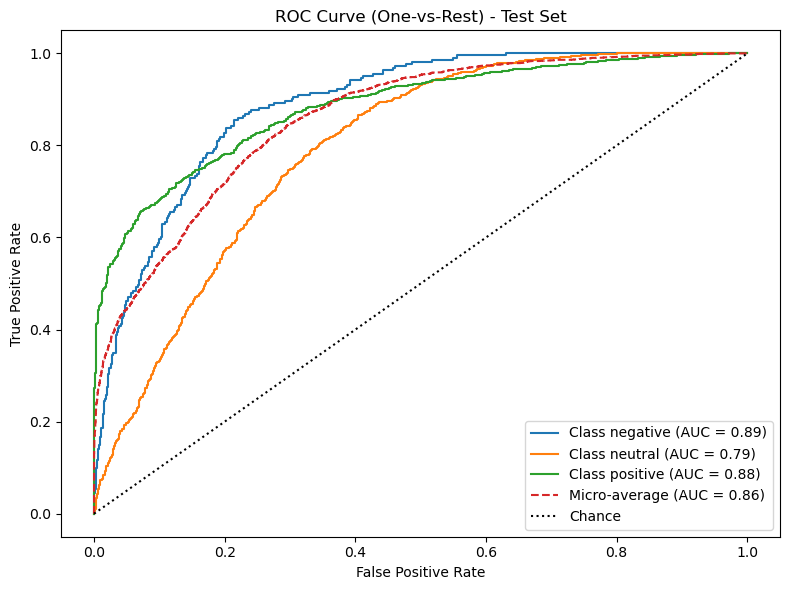

<Figure size 800x600 with 0 Axes>

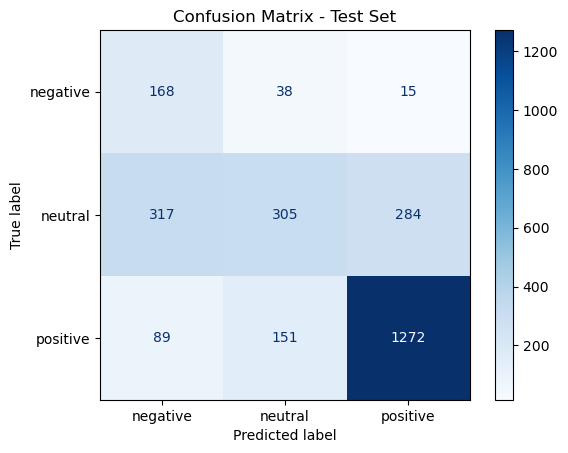

In [47]:
from sklearn.naive_bayes import MultinomialNB

pipeline = ImbPipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                tokenizer=stem_tokenizer,  # Tokenize with custom stemmer function with error handling
                lowercase=True,
                max_features=5000,
                token_pattern=None,  # Explicitly disable default token pattern
            ),
        ),
        ("smote", SMOTE(random_state=42)),  # Handle class imbalance
        (
            "classifier",
            MultinomialNB(),
        ),
    ]
)

# Define parameter grid for random search
param_dist = {
    "tfidf__max_features": [1000, 5000, 10000, None],  # Number of features
    "tfidf__ngram_range": [(1, 1), (1, 2)],  # Unigrams and bigrams
    "smote__k_neighbors": [3, 5, 7],  # Number of nearest neighbors
    "classifier__alpha": [0.5, 1.0],
    "classifier__fit_prior": [True, False],
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter combinations to try
    scoring="accuracy",  # Optimize for accuracy
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1,
)

# Perform random search on training data
print("Starting randomized grid search...")
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Evaluate the best model
print("\nBest model evaluation:")
score["MutinomialNB"] = evaluate_model(best_model, X_train, y_train, X_test, y_test, le.classes_)

In [50]:
score

,Logistic Regression,Random Forest,MLP,MutinomialNB
Train Accuracy,0.872465,0.914819,0.887720,0.767766
Train Precision,0.885119,0.919719,0.893630,0.807020
Train Recall,0.872465,0.914819,0.887720,0.767766
Train F1,0.875992,0.915238,0.889135,0.771049
Train ROC AUC,0.967737,0.977843,0.972269,0.933898
Test Accuracy,0.796135,0.743085,0.811671,0.661235
Test Precision,0.819076,0.747609,0.824655,0.700373
Test Recall,0.796135,0.743085,0.811671,0.661235
Test F1,0.803843,0.745218,0.815937,0.657756
Test ROC AUC,0.922255,0.860097,0.931173,0.854354


# Embedding-based approach

In [51]:
def load_glove_model(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = list(map(float, values[1:]))
            embeddings_index[word] = vector
    return embeddings_index

glove_embeddings = load_glove_model("glove.6B.100d.txt")

In [52]:
def get_average_embedding(tokens, embeddings, dim=100):
    valid_vectors = [embeddings[word] for word in tokens if word in embeddings]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(dim)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = np.vstack(df['vector'].values)
y = df['sentiments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

In [74]:
# 1. Imports & setup
import os
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# If you haven't already:
# pip install nltk scikit-learn

import nltk
nltk.download('punkt')


# 2. Load your data
# Adjust the path to wherever your CSV is stored.
df = pd.read_csv("amazon_reviews.csv")  
# Expected columns: sentiments, cleaned_review, cleaned_review_length, review_score

# Quick sanity check
print(df.head())


# 3. Preprocessing function
def preprocess(text):
    # text = text.lower()
    # remove anything that's not a letter or space
    # text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    return tokens
  
  
def stem_tokenizer(text):
  try:
      tokens = word_tokenize(text)
      return [stemmer.stem(token) for token in tokens]
  except:
      return []  # Return empty list for problematic texts

df['tokens'] = df['cleaned_review'].apply(stem_tokenizer)


# 4. Load GloVe embeddings
# Download from: http://nlp.stanford.edu/data/glove.6B.zip
# Unzip and point GLOVE_PATH at glove.6B.100d.txt
GLOVE_PATH = "glove.6B.300d.txt"

def load_glove(glove_path):
    emb_index = {}
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vec = np.asarray(parts[1:], dtype='float32')
            emb_index[word] = vec
    return emb_index

print("Loading GloVe embeddings (this may take a minute)…")
glove_index = load_glove(GLOVE_PATH)
EMB_DIM = 300
print(f"  → loaded {len(glove_index)} word vectors.")


# 5. Turn each review into an average-embedding vector
def avg_embedding(tokens, emb_index, dim=EMB_DIM):
    vecs = [emb_index[w] for w in tokens if w in emb_index]
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(dim)

# Apply and stack into an array
df['emb_vector'] = df['tokens'].apply(lambda toks: avg_embedding(toks, glove_index))
X = np.stack(df['emb_vector'].values)
y = df['sentiments']  # your labels: 'negative', 'neutral', 'positive'


# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 7. Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


# 8. Evaluate
y_pred = clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

[nltk_data] Downloading package punkt to C:\Users\tamqu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  sentiments                                     cleaned_review  \
0   positive  i wish would have gotten one earlier love it a...   
1    neutral  i ve learned this lesson again open the packag...   
2    neutral          it is so slow and lags find better option   
3    neutral  roller ball stopped working within months of m...   
4    neutral  i like the color and size but it few days out ...   

   cleaned_review_length  review_score  
0                     19           5.0  
1                     88           1.0  
2                      9           2.0  
3                     12           1.0  
4                     21           1.0  
Loading GloVe embeddings (this may take a minute)…
  → loaded 400000 word vectors.
=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.5106    0.1564    0.2394       307
     neutral     0.6393    0.6788    0.6585      1261
    positive     0.7961    0.8526    0.8234      1900

    accuracy        

In [75]:
accuracy_score(y_test, y_pred)

0.7277970011534025

In [77]:
# 1. Imports & setup
import os
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec

# If you haven't already:
# pip install nltk scikit-learn gensim

import nltk
nltk.download('punkt')  # for tokenization

# 2. Load your data
# Adjust the path to wherever your CSV is stored.
df = pd.read_csv("amazon_reviews.csv")  
# Expected columns: sentiments, cleaned_review, cleaned_review_length, review_score

# Quick sanity check
print(df.head())

# 3. Preprocessing function
def stem_tokenizer(text):
  try:
      tokens = word_tokenize(text)
      return [stemmer.stem(token) for token in tokens]
  except:
      return []  # Return empty list for problematic texts

# Apply preprocessing
df['tokens'] = df['cleaned_review'].apply(stem_tokenizer)

# 4. Train a Word2Vec model on your tokens
# You can adjust vector_size, window, min_count as needed
W2V_DIM = 300
w2v_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=W2V_DIM,
    window=5,
    min_count=2,
    workers=os.cpu_count(),
    seed=42
)

# 5. Turn each review into an average-embedding vector from Word2Vec
def avg_w2v(tokens, model, dim=W2V_DIM):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(dim)

# Apply and stack into an array
df['emb_vector'] = df['tokens'].apply(lambda toks: avg_w2v(toks, w2v_model))
X = np.stack(df['emb_vector'].values)
y = df['sentiments']  # labels: 'negative', 'neutral', 'positive'

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7. Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# 8. Evaluate
y_pred = clf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# 9. Save model for later
import joblib
joblib.dump(w2v_model, "w2v_sentiment_model.model")
joblib.dump(clf, "w2v_logreg_sentiment.pkl")


[nltk_data] Downloading package punkt to C:\Users\tamqu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  sentiments                                     cleaned_review  \
0   positive  i wish would have gotten one earlier love it a...   
1    neutral  i ve learned this lesson again open the packag...   
2    neutral          it is so slow and lags find better option   
3    neutral  roller ball stopped working within months of m...   
4    neutral  i like the color and size but it few days out ...   

   cleaned_review_length  review_score  
0                     19           5.0  
1                     88           1.0  
2                      9           2.0  
3                     12           1.0  
4                     21           1.0  
=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.3333    0.0651    0.1090       307
     neutral     0.6117    0.6495    0.6300      1261
    positive     0.7786    0.8479    0.8118      1900

    accuracy                         0.7065      3468
   macro avg     0.5745    0.5208    0.5169      

['w2v_logreg_sentiment.pkl']

In [78]:
accuracy_score(y_test, y_pred)

0.7064590542099193

In [92]:
from sklearn.naive_bayes import MultinomialNB

pipeline = ImbPipeline(
    [
        # ("smote", SMOTE(random_state=42)),  # Handle class imbalance
        (
            "classifier",
            # MLPClassifier(),
            MLPClassifier()
        ),
    ]
)

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

    negative     0.5464    0.3453    0.4232       307
     neutral     0.7371    0.7581    0.7475      1261
    positive     0.8569    0.8916    0.8739      1900

    accuracy                         0.7947      3468
   macro avg     0.7134    0.6650    0.6815      3468
weighted avg     0.7858    0.7947    0.7880      3468

=== Confusion Matrix ===
[[ 106  158   43]
 [  65  956  240]
 [  23  183 1694]]


c:\Users\tamqu\anaconda3\envs\study\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [91]:
accuracy_score(y_test, y_pred)

0.7840253748558247